In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from PIL import Image

In [45]:
#select the mode of panoptic
#set the path of picture/mask/label
panoptic_mode = int(input("Select the mode of panoptic: 1 for DETR, 2 for SETR: "))
if panoptic_mode == 1:
    Filepath = './DETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'
    
elif panoptic_mode == 2:
    Filepath = './SETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'

Select the mode of panoptic: 1 for DETR, 2 for SETR:  1


In [46]:
# create a dictionary to store the mask and label and category
def read_masks_and_labels(mask_label_path):
    labels = []
    categories = []

    with open(mask_label_path + 'image_categories.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(',')
            label = parts[0].split(':')[1].strip()
            category = parts[1].split(':')[1].strip()
            labels.append(int(label))
            categories.append(category)

    masks = []
    mask_dict = {}
    
    for i, ID in enumerate (labels):
        filename = 'mask_class_' + str(ID) + '.png'
        mask = cv2.imread(mask_label_path + filename, cv2.IMREAD_GRAYSCALE)
        masks = np.array(mask)
        mask_dict[i] = {'labels': labels[i], 'categories': categories[i], 'masks': masks}
        
    return mask_dict

# Use the function to read masks and labels
mask_dict1 = read_masks_and_labels(mask_label_path1)
mask_dict2 = read_masks_and_labels(mask_label_path2)

In [47]:
# print(mask_dict1)
# print(mask_dict2)

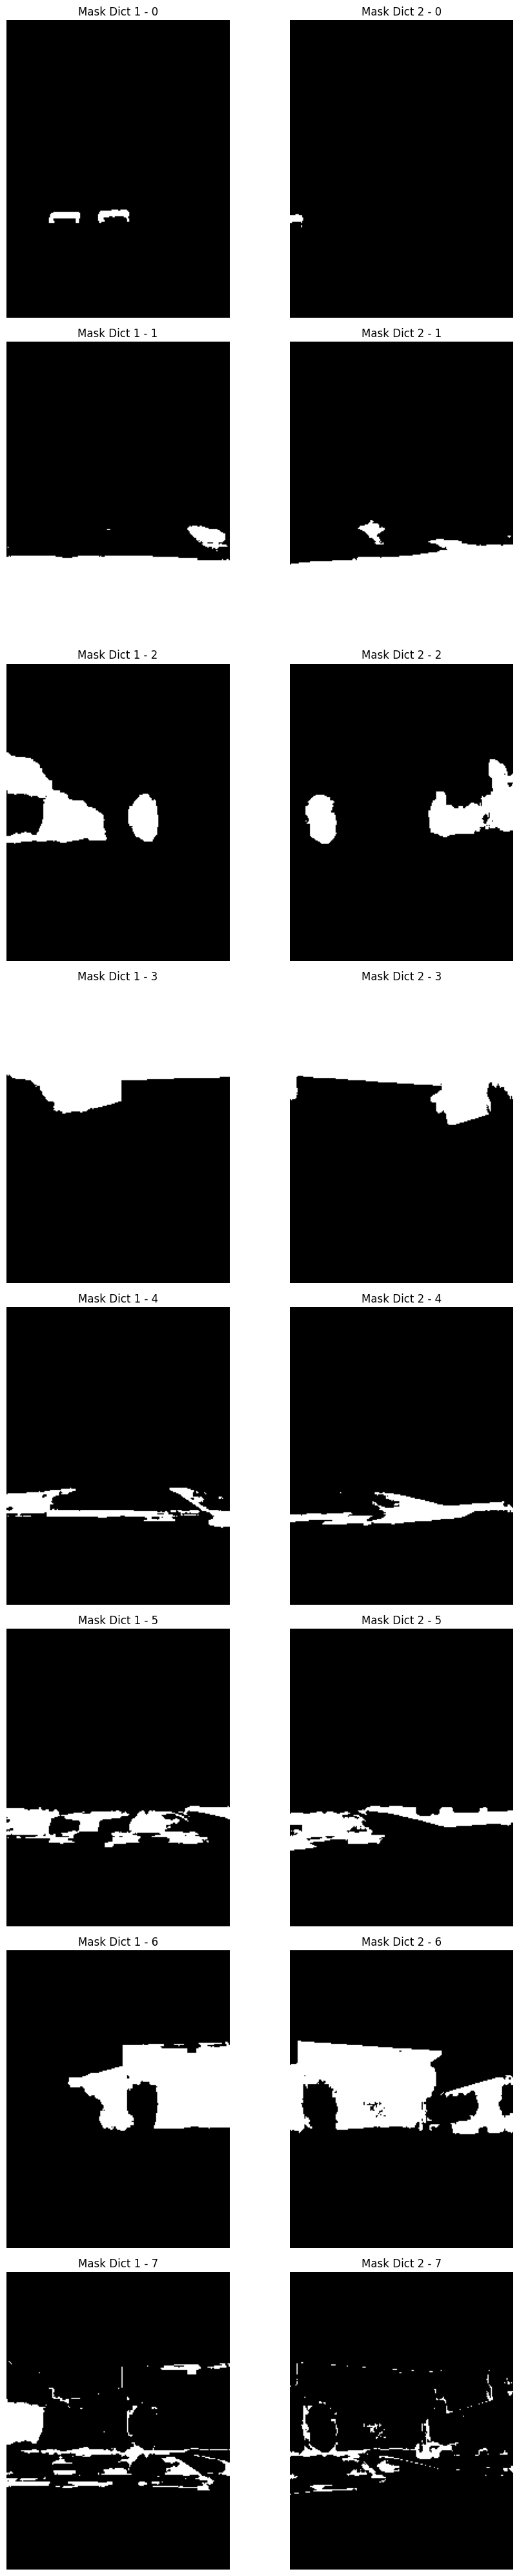

In [48]:
def get_id_from_dict(mask_dict):
    ids = set()
    for i in range(len(mask_dict)):
        ids.add(mask_dict[i]['labels'])
    return ids

def invert_intersection_masks(modified_dict):
    # Stack and invert masks for the intersection
    if len(modified_dict) > 0:
        intersection_label = 99
        intersection_masks = np.stack([item['masks'] for item in modified_dict.values()])
        intersection_mask = np.bitwise_not(np.bitwise_or.reduce(intersection_masks, axis=0))
        modified_dict[len(modified_dict)] = {
            'labels': intersection_label,
            'categories': 'others',
            'masks': intersection_mask
        } 
    return modified_dict

def modified_dict_by_class(mask_dict1, mask_dict2):
    # Create sets to store the IDs of each dictionary
    ids_dict1 = get_id_from_dict(mask_dict1)
    ids_dict2 = get_id_from_dict(mask_dict2)

    # print(ids_dict1)
    # print(ids_dict2)
    
    # Create dictionaries to store matched and unmatched items
    same_dict1 = {}
    same_dict2 = {}
    counter1 = 0
    counter2 = 0
    
    # Process the first dictionary
    for key in mask_dict1:
        if mask_dict1[key]['labels'] in ids_dict2:
            same_dict1[counter1] = mask_dict1[key]
            counter1+=1
    
    # Process the second dictionary
    for key in mask_dict2:
        if mask_dict2[key]['labels'] in ids_dict1:
            same_dict2[counter2] = mask_dict2[key]
            counter2+=1

    modified_dict1 = {}
    modified_dict2 = {}
    
    modified_dict1 = invert_intersection_masks(same_dict1)
    modified_dict2 = invert_intersection_masks(same_dict2)
  
    return modified_dict1, modified_dict2

def display_masks_side_by_side(mask_dict1, mask_dict2):
    max_len = max(len(mask_dict1), len(mask_dict2))
    
    fig, axes = plt.subplots(max_len, 2, figsize=(10, 5 * max_len))
    
    for i in range(max_len):
        if i < len(mask_dict1):
            mask1 = mask_dict1[i]['masks']
            axes[i, 0].imshow(mask1, cmap='gray')
            axes[i, 0].set_title(f'Mask Dict 1 - {i}')
            axes[i, 0].axis('off')
        else:
            axes[i, 0].axis('off')
        
        if i < len(mask_dict2):
            mask2 = mask_dict2[i]['masks']
            axes[i, 1].imshow(mask2, cmap='gray')
            axes[i, 1].set_title(f'Mask Dict 2 - {i}')
            axes[i, 1].axis('off')
        else:
            axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


modified_dict1, modified_dict2 = modified_dict_by_class(mask_dict1, mask_dict2)

# Display the masks side by side
display_masks_side_by_side(modified_dict1, modified_dict2)


In [49]:
# print(modified_dict1)
# print(modified_dict2)

In [50]:
#SIFT
#create the feature point
# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [51]:
def process_image(gray, mask):
    mask = cv2.resize(mask, (gray.shape[1], gray.shape[0]))

    gray_array = np.array(gray)
    mask_array = np.array(mask)

    # Ensure the mask is binary (i.e., contains only 0s and 1s)
    binary_mask = (mask_array > 0).astype(np.uint8)

    # Perform dilation on the binary mask
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=5)

    # Use the mask to crop the grayscale image
    cropped_gray = gray_array * dilated_mask

    # Convert the cropped result back to an image
    cropped_gray_image = Image.fromarray(cropped_gray)
    
    return cropped_gray_image


def process_images_and_store(gray, mask_dict):
    # Create a dictionary to store the processed images and their categories
    processed_images = {}

    # Loop over each mask in the mask dictionary
    for i in range(len(mask_dict)):
        # Process the image
        processed_image = process_image(gray, mask_dict[i]['masks'])
        processed_image = np.array(processed_image)
        
        # Get the category for this image
        category = mask_dict[i]['categories']
        
        # Get the label for this image
        label = mask_dict[i]['labels']
        
        # Save the processed image and its category to the dictionary
        processed_images[i] = {'label': label, 'category': category, 'image': processed_image}
    
    return processed_images

In [52]:
# Use the function to process the images and store them in dictionaries
processed_images1 = process_images_and_store(gray1, modified_dict1)
processed_images2 = process_images_and_store(gray2, modified_dict2)

In [53]:
# plt.imshow(processed_images1[1]['image'], cmap='gray')

In [54]:
# plt.imshow(processed_images2[1]['image'], cmap='gray')

In [55]:
# processed_images1[2]['image']

In [56]:
# gray1

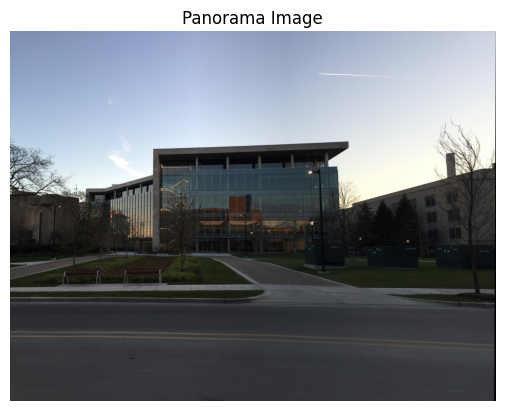

Panorama created successfully!


In [92]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

class Image_Stitching():
    def __init__(self):
        self.ratio = 0.85
        self.min_match = 10
        self.sift = cv2.SIFT_create()
        self.smoothing_window_size = 800

    def registration(self, img1, img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches = []
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
            return H
        else:
            raise AssertionError("Can't find enough keypoints.")

    def create_mask(self, img1, img2, version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self, img1, img2):
        H = self.registration(img1, img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 + width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1, img2, version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1, img2, version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
        result = panorama1 + panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result.astype(np.uint8)  # Ensure the data type is uint8

def main(argv1, argv2):
    img1 = cv2.imread(argv1)
    img2 = cv2.imread(argv2)
    final = Image_Stitching().blending(img1, img2)

    # Display the panorama using matplotlib
    final_rgb = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(final_rgb)
    plt.title('Panorama Image')
    plt.axis('off')
    plt.show()

# Example usage
try:
    main('image1.jpg', 'image2.jpg')
    print("Panorama created successfully!")
except IndexError:
    print("Please input two source images.")
